<a href="https://colab.research.google.com/github/statistics-jun/2022-1-ESAA/blob/main/ESAA_0321_house_price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2022-1 ESAA 5기 김혜준 실습 필사 - 0321(월) 3주차 과제
## Stacked Regressions : Top 4% on LeaderBoard
House Prices - Advanced Regression Techniques

### Stacked Regressions to predict House Prices

In [1]:
# import some necessary libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt # Matlab-style plotting
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
  pass
warnings.warn = ignore_warn # ignore annoying warning (from sklearn and seaborn)

from scipy import stats
from scipy.stats import norm, skew # for some statistics

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) # Limiting floats output to 3 decimal points

from subprocess import check_output
print(check_output(["ls", "/content/drive/MyDrive/ESAA/2022-1/과제/실습 필사/0321(월) 3주차 과제"]).decode("utf8")) # check the files available in the directory

data_description.txt
ESAA_0321_house_price.ipynb
sample_submission.csv
test.csv
train.csv



In [2]:
# Now let's import and put the train and test datasets in pandas dataframe
train = pd.read_csv('/content/drive/MyDrive/ESAA/2022-1/과제/실습 필사/0321(월) 3주차 과제/train.csv')
test = pd.read_csv('/content/drive/MyDrive/ESAA/2022-1/과제/실습 필사/0321(월) 3주차 과제/test.csv')

In [3]:
## display the first five rows of the train dataset
train.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
## display the first five rows of the test dataset
test.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [5]:
# check the numbers of samples and features
print("The train data size before dropping Id feature is : {}".format(train.shape))
print("The test data size before dropping Id feature is : {}".format(test.shape))

# Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

# Now drop the 'Id' column since it's unnecessary for the prediction process
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

# check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {}".format(train.shape))
print("The test data size after dropping Id feature is : {}".format(test.shape))

The train data size before dropping Id feature is : (1460, 81)
The test data size before dropping Id feature is : (1459, 80)

The train data size after dropping Id feature is : (1460, 80)
The test data size after dropping Id feature is : (1459, 79)


### Data Processing
#### Outliers
* 훈련 데이터에 outlier 존재

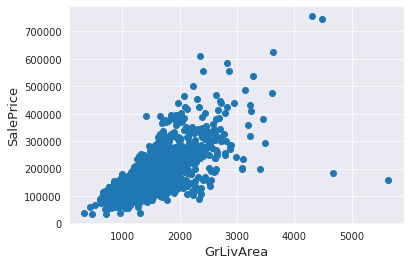

In [6]:
# 그래프 그려 outlier 확인
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

* 오른쪽 아래 2개의 outlier 존재 : 매우 큰 GrLivArea, 낮은 가격

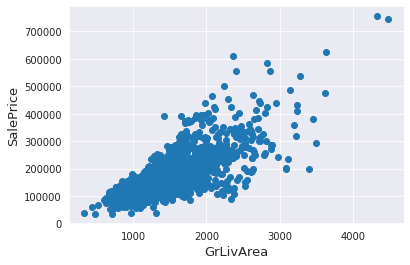

In [7]:
# Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

# Check the graphic again
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

* 테스트 데이터에 outlier가 있는 경우, 훈련 데이터의 모든 outlier를 제거하는 것은 좋지 않음

#### Target Variable
* SalePrice


 mu = 180932.92 and sigma = 79467.79



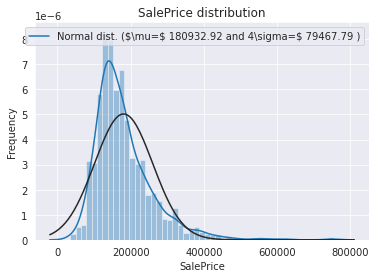

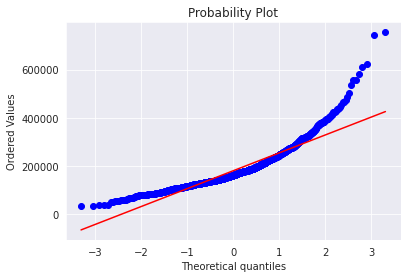

In [8]:
# SalePrice 변수 분석
sns.distplot(train['SalePrice'], fit = norm)

# Get the fitted parameters used by function
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and 4\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

* 타겟 변수는 right skewed
  -> 정규 분포가 되도록 tranfromation 필요

##### Log-transformation of the target variable


 mu = 12.02 and sigma = 0.40



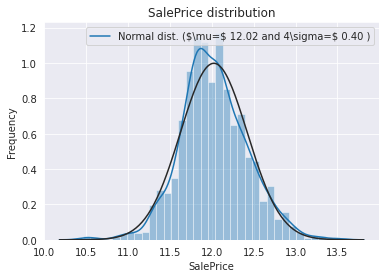

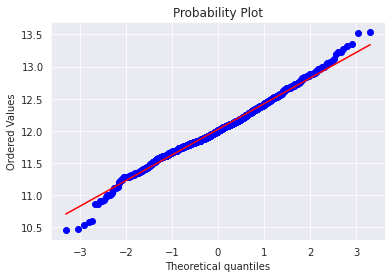

In [9]:
# We use the numpy function log1p which applies log(1+x) to all elements of the column
train['SalePrice'] = np.log1p(train['SalePrice'])

# Check the new distribution
sns.distplot(train['SalePrice'], fit = norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print('\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

# Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and 4\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

# Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

* 왜곡이 수정되어 데이터가 정규 분포로 나타남

### Features engineering

In [10]:
# 같은 DataFrame에 train, test data 병합
ntrain = train.shape[0]
ntest = test.shape[0]
y_train = train.SalePrice.values
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis = 1, inplace = True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2917, 79)


#### Missing Data

In [11]:
# 결측치 비율 계산
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageQual,5.451
GarageCond,5.451
GarageYrBlt,5.451


Text(0.5, 1.0, 'Percent missing data by feature')

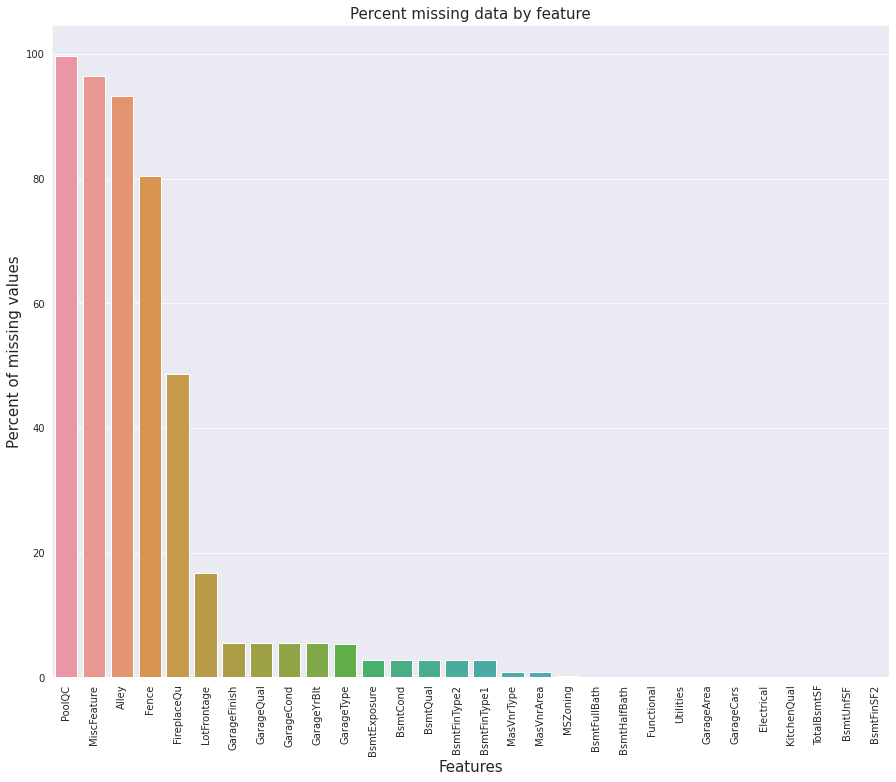

In [12]:
# 결측치 확률 그래프 그리기
f, ax = plt.subplots(figsize=(15, 12))
plt.xticks(rotation = '90')
sns.barplot(x = all_data_na.index, y = all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

##### Data Correlation

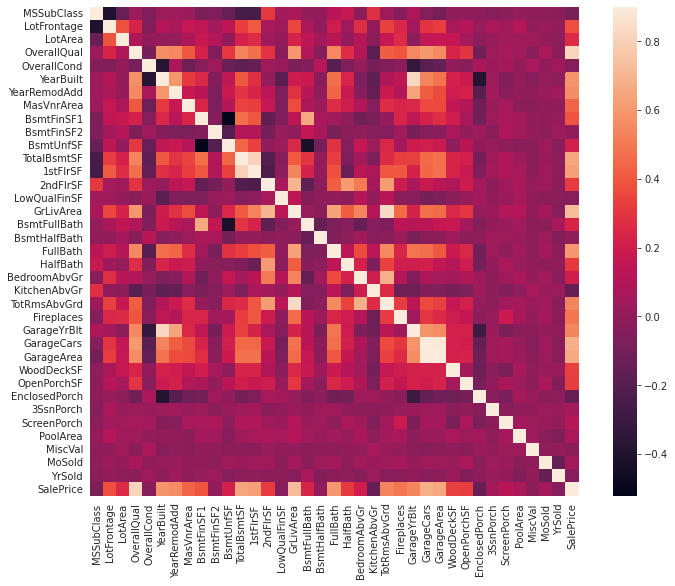

In [13]:
# Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

#### Imputing missing values
결측치가 있는 feature들을 순차적으로 진행하며 보간
* **PoolQC** : NA = "No Pool"
  
  => 큰 결측값 비율(+99%) & 대부분의 집에는 풀이 없음
  
  => 의미 有

In [14]:
# PoolQC
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")

* **MiscFeature** : NA = "no misc feature"

In [15]:
# MiscFeature
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")

* **Alley** : NA = "no alley access"

In [16]:
# Alley
all_data["Alley"] = all_data["Alley"].fillna("None")

* **Fence** : NA = "no fence"

In [17]:
# Fence
all_data["Fence"] = all_data["Fence"].fillna("None")

* **FireplaceQu** : NA = "no fireplace"

In [18]:
# FireplaceQu
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")

* **LotFrontage** : 집에 연결된 거리의 면적은 이웃의 다른 집과 비슷할 가능성이 높음 -> 결측치에 이웃의 LotFrontage median 값을 채움 

In [19]:
# Group by neighborhood and fill in missing value b median LotFrontage of all the neighborhood
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

* **GarageType, GarageFinish, GarageQual, and GarageCond** : 결측치를 None으로 대체

In [20]:
# GarageType, GarageFinish, GarageQual, and GarageCond 
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
  all_data[col] = all_data[col].fillna('None')

* **GarageYrBlt, GarageArea, and GarageCars** : 결측치를 0으로 대체 (왜냐하면 No garage = no cars in such garage)

In [21]:
# GarageYrBlt, GarageArea, and GarageCars
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
  all_data[col] = all_data[col].fillna(0)

* **BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, and BsmtHalfBath** : basement가 없으면 결측치가 0일 가능성이 높음 

In [22]:
# BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, and BsmtHalfBath
for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
  all_data[col] = all_data[col].fillna(0)

*  **BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, and BsmtFinType2**(지하실과 연관된 범주형 변수) : NaN = "no basement"

In [23]:
# BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, and BsmtFinType2
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
  all_data[col] = all_data[col].fillna('None')

* **MasVnrArea and MasVnrType** : NA = "no masonry veneer"

  -> Area 결측치에는 0, Type 결측치에는 None

In [24]:
# MasVnrArea and MasVnrType
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

* **MSZoning (The general zoning classification)** : 결측치를 가장 흔한 값 'RL'로 대체

In [25]:
# MSZoning
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

* **Utilities** : "NoSeWa"와 2개의 NA를 제외한 모든 레코드가 "AllPub"

  - "NoSeWa"가 있는 집이 훈련 데이터 세트에 존재

  -> 예측 모델링에 도움 되지 않음

  => 특성 제거

In [26]:
# Utilities
all_data = all_data.drop(['Utilities'], axis=1)

* **Functional** : NA = "typical"

In [27]:
# Functional
all_data["Functional"] = all_data["Functional"].fillna("Typ")

* **Electrical** : 하나의 NA 값 존재

  -> 대부분은 'SBrkr'이므로 결측치를 'SBrkr'로 대체

In [28]:
# Electrical
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

* **KitchenQual** : 하나의 NA 값 존재

  -> 최빈값 'TA'로 결측치 대체

In [29]:
# KitchenQual
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

* **Exterior1st and Exterior2nd** : 두 변수 모두 하나의 결측치 존재

  -> 가장 흔한 string으로 대체

In [30]:
# Exterior1st and Exterior2nd
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

* **SaleType** : 결측치를 최빈값 "WD"로 대체

In [31]:
# SaleType
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

* **MSSubClass** : NA = "No building class"

  -> 결측치를 None으로 대체

In [32]:
# MSSubClass
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [33]:
# Check remaining missing values if any
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head() 

,Missing Ratio


* 모든 결측치 제거 완료

#### More features engineering
##### Transforming some numerical variables that are really categorical

In [34]:
# MSSubClass = The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

# Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

# Year and month sold are transformed into categorical features
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

##### Label Encoding some categorical variables that may contain information in their ordering set

In [35]:
# Label Encoding
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond',
        'ExterQual', 'ExterCond', 'HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1',
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond',
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
  lbl = LabelEncoder()
  lbl.fit(list(all_data[c].values))
  all_data[c] = lbl.transform(list(all_data[c].values))

# shape
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (2917, 78)


##### Adding one more important feature
* 면적 관련 feature들은 집값 결정에 매우 중요
  
  => 총 면적 feature 추가 (the total area of basement, first, and second floor areas of each house)

In [36]:
# Adding total sqfootage feature
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

##### Skewed features

In [37]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


##### Box Cox Transformation of (highly) skewed features
* scipy의 boxcox1p 함수를 사용하여 $1 + x$의 Box-Cox Transformation 계산
* $\lambda = 0$ 설정 : target variable에 사용한 log1p와 동일

In [38]:
# Box-Cox Transformation
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
  # all_data[feat] += 1
  all_data[feat] = boxcox1p(all_data[feat], lam)

# all_data[skewed_features] = np.log1p(all_data[skewed_features])

There are 59 skewed numerical features to Box Cox transform


##### Getting dummy categorical features

In [39]:
# dummy categorical feature
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2917, 220)


In [40]:
# 새로운 train/test set 가져오기
train = all_data[:ntrain]
test = all_data[ntrain:]

### Modeling

In [44]:
# 라이브러리 임포트
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

##### Define a cross validation strategy
* sklearn의 cross_val_score 함수 사용
  - shuffle 속성 없음 -> 교차 검증 수행 전에 데이터셋을 shuffle하기 위한 코드 추가 필요

In [45]:
# Validation fuction
n_folds = 5

def rmsle_cv(model):
  kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
  rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
  return(rmse)

#### Base models
* **LASSO Regression**
  - outlier에 매우 민감
  
    -> sklearn의 Robustscaler() 메서드 사용 

In [46]:
# LASSO Regression
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.0005, random_state=1))

* **Elastic Net Regression** : sklearn의 Robustscaler() 메서드 사용

In [47]:
# Elastic Net Regression
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha = 0.0005, l1_ratio = .9, random_state=3))

* **Kernel Ridge Regression**

In [48]:
# Kernel Ridge Regression
KRR = KernelRidge(alpha = 0.6, kernel = 'polynomial', degree = 2, coef0 = 2.5)

* **Gradient Boosting Regression** : outlier에 견고하도록 해주는 huber loss 사용

In [49]:
# Gradient Boosting Regression
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10,
                                   loss='huber', random_state=5)

* **XGBoost**

In [50]:
# XGBoost
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468,
                             learning_rate=0.05, max_depth=3,
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state=7, nthread = -1)

* **LightGBM**

In [51]:
# LightGBM
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed = 9, bagging_seed = 9,
                              min_data_in_leaf = 6, min_sum_hessian_in_leaf = 11)

#### Base models scores
* 교차 검증 rmsle error로 평가

In [53]:
# LASSO Regression
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1115 (0.0074)



In [54]:
# Elastic Net Regression
score = rmsle_cv(ENet)
print("\nElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


ElasticNet score: 0.1116 (0.0074)



In [55]:
# Kernel Ridge Regression
score = rmsle_cv(KRR)
print("\nKernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Kernel Ridge score: 0.1153 (0.0075)



In [56]:
# Gradient Boosting Regression
score = rmsle_cv(GBoost)
print("\nGradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Gradient Boosting score: 0.1167 (0.0083)



In [57]:
# XGBoost
score = rmsle_cv(model_xgb)
print("\nXgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Xgboost score: 0.1150 (0.0066)



In [58]:
# LightGBM
score = rmsle_cv(model_lgb)
print("\nLGBM score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


LGBM score: 0.1176 (0.0062)



### Stacking models
#### Simplest Stacking approach : Averaging base models
* 사이킷런을 모델로 확장하고, encapsulation과 코드 재사용(상속)을 활용하기 위해 새로운 class 생성

##### Averaged base models class

In [61]:
# Averaged base models class
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

##### Averaged base models score
* 네 개의 모델 (ENet, GBoost, KRR and lasso)의 평균 계산

In [62]:
# Averaged base models score
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1087 (0.0077)



#### Less simple stacking : Adding a Meta-model
* averaged base model에 meta-model을 추가 

  -> base model의 out-of-folds prediction을 사용하여 meta-model 훈련

* 훈련 절차

1. total training set를 두 개의 disjoint set으로 분리 (train &  .holdout )
2. 첫 번째 파트에서 여러 base model 학습(train)
3. 두 번째 파트에서 이러한 base model 테스트(holdout).
4. 3)의 예측(out-of-folds predictions)을 input, correct responses (target variable)을 output으로 사용하여 meta-model 훈련

  - 처음 세 단계는 반복적으로 수행
  - 전체 데이터가 out-of-folds prediction을 얻는 데 사용
    
    -> 네 번째 단계에서 meta-model을 훈련하기 위한 새로운 feature로 사용

  - Prediction : test data에 대한 모든 base model의 예측을 평균화하고 meta-feature로 사용
  - Final Prediction : meta-model로 수행

  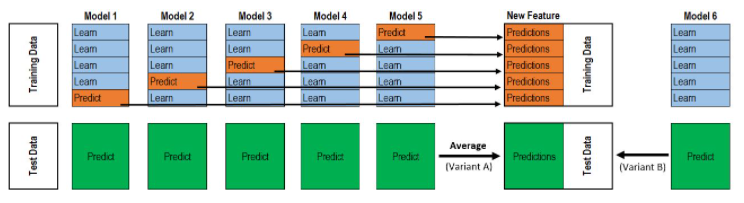

##### Stacking averaged Models Class

In [63]:
# Stacking averaged Models Class
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

##### Stacking Averaged models Score
* 두 접근법을 비교하기 위해 동일한 수의 모델 사용
  - ENet, KRR, GBoost 모델 평균

    -> meta-model로 lasso를 사용

In [64]:
# Stacking Averaged models Score
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1081 (0.0073)


### Ensembling StackedRegressor, XGBoost and LightGBM
* StackedRegressor, XGBoost, LightGBM

In [65]:
# rmsle evaluation function
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

#### Final Training and Prediction
##### **StackedRegressor**

In [66]:
# StackedRegressor
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.07839506096664638


##### **XGBoost**

In [67]:
# XGBoost
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.0788580427618937


##### **LightGBM**

In [68]:
# LightGBM
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test.values))
print(rmsle(y_train, lgb_train_pred))

0.07294132053731643


In [69]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.07566957841091904


##### **Ensemble prediction**

In [70]:
# Ensemble prediction
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

##### **Submission**

In [71]:
# Submission
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = ensemble
sub.to_csv('submission.csv',index=False)